In [81]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import robust_filter as rfilter
from functools import partial

In [148]:
import seaborn as sns

In [150]:
sns.set_palette("colorblind")

In [151]:
%config InlineBackend.figure_format = "retina"

In [316]:
plt.rcParams["font.size"] = 15

In [152]:
key = jax.random.PRNGKey(314)

In [153]:
n_steps = 2000

In [426]:
def step(sprev, key):
    key_next, key_shock, key_outlier, key_obs = jax.random.split(key, 4)
    shock = jax.random.exponential(key_shock)
    snext = jax.random.normal(key_next) * shock * 0.01 + sprev

    is_outlier = jax.random.uniform(key_outlier) < 0.01
    
    obs_clean = jnp.exp(snext)
    obs = obs_clean * (1 - is_outlier) + 2 * is_outlier
    obs = obs + jax.random.gamma(key_obs, a=1/2)
    
    out = {
        "s": snext,
        "obs_clean": obs_clean,
        "obs": obs
    }
    return snext, out

In [427]:
keys = jax.random.split(key, n_steps)
s0 = 0.01
_, hist = jax.lax.scan(step, s0, keys)

In [428]:
from rebayes_mini.methods import gauss_filter as gf

In [429]:
def latent_fn(x): return x
def measurement_fn(latent, x): return latent

In [430]:
y = hist["obs"][:, None]

In [431]:
x = jnp.ones_like(y)

In [432]:
agent = gf.ExtendedKalmanFilter(
        latent_fn, measurement_fn, dynamics_covariance=1.0,
        observation_covariance=1.0 * jnp.eye(1),
    )

lr = 1.0
bel_init = agent.init_bel(0.0, cov=lr)
# callback = partial(callback_fn, applyfn=agent.vobs_fn)
bel, yhat_pp = agent.scan(bel_init, y, x[:, None], callback_fn=callbacks.get_updated_mean)


In [433]:
agent = rfilter.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn, dynamics_covariance=1.0,
        observation_covariance=1.0 * jnp.eye(1),
        soft_threshold=0.1
    )

lr = 1.0
bel_init = agent.init_bel(1.0, cov=lr)
bel, yhat_pp_imq = agent.scan(bel_init, y, x[:, None], callback_fn=callbacks.get_updated_mean)


In [434]:
agent = rfilter.ExtendedKalmanFilterInverseWishart(
        latent_fn, measurement_fn, dynamics_covariance=1.0,
        prior_observation_covariance=1.0 * jnp.eye(1),
        n_inner=3, noise_scaling=0.1,
    )

lr = 1.0
bel_init = agent.init_bel(1.0, cov=lr)
bel, yhat_pp_md = agent.scan(bel_init, y, x[:, None], callback_fn=callbacks.get_updated_mean)


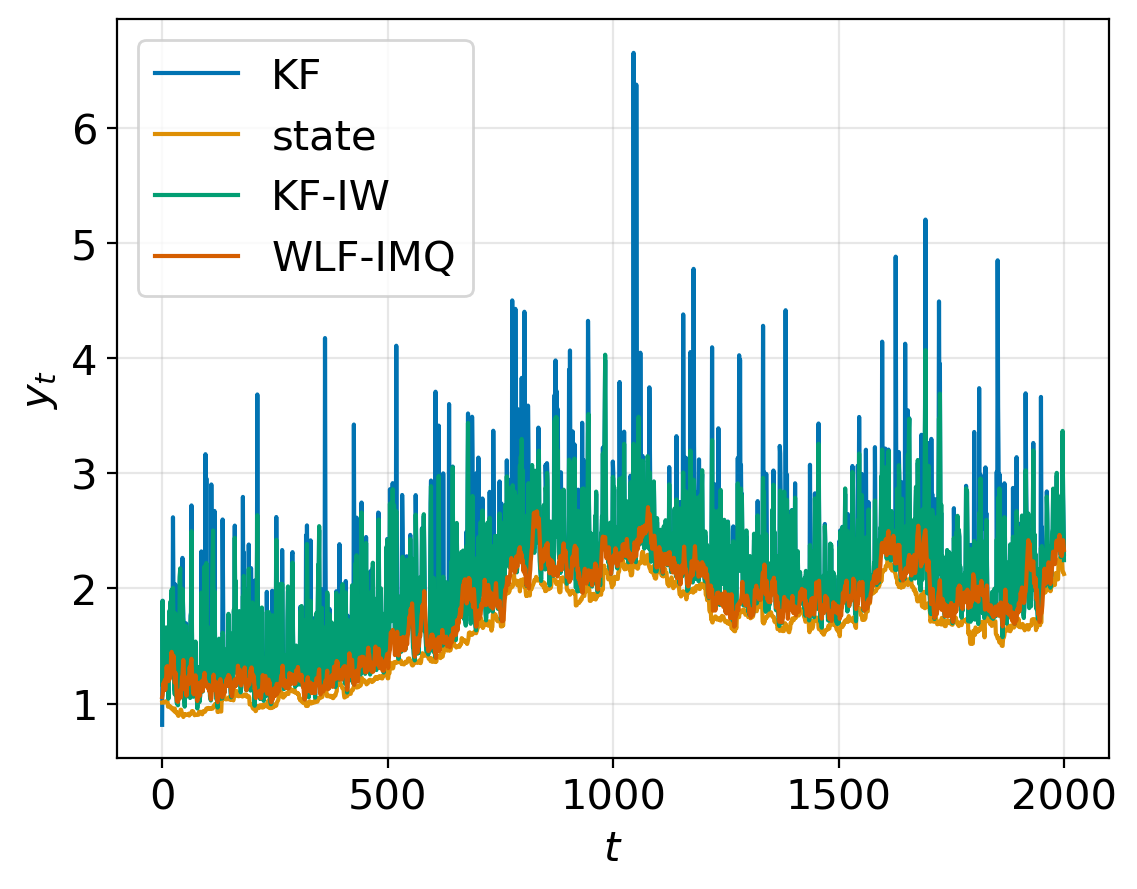

In [438]:
fig, ax = plt.subplots()
plt.plot(yhat_pp, label="KF")
plt.plot(jnp.exp(hist["s"]), label="state")
plt.plot(yhat_pp_md, label="KF-IW")
plt.plot(yhat_pp_imq, label="WLF-IMQ")
plt.grid(alpha=0.3)
plt.xlabel("$t$")
plt.ylabel("$y_t$")
plt.legend()
plt.savefig("./20240404-gamma-process.png", dpi=150)

## Multiple values

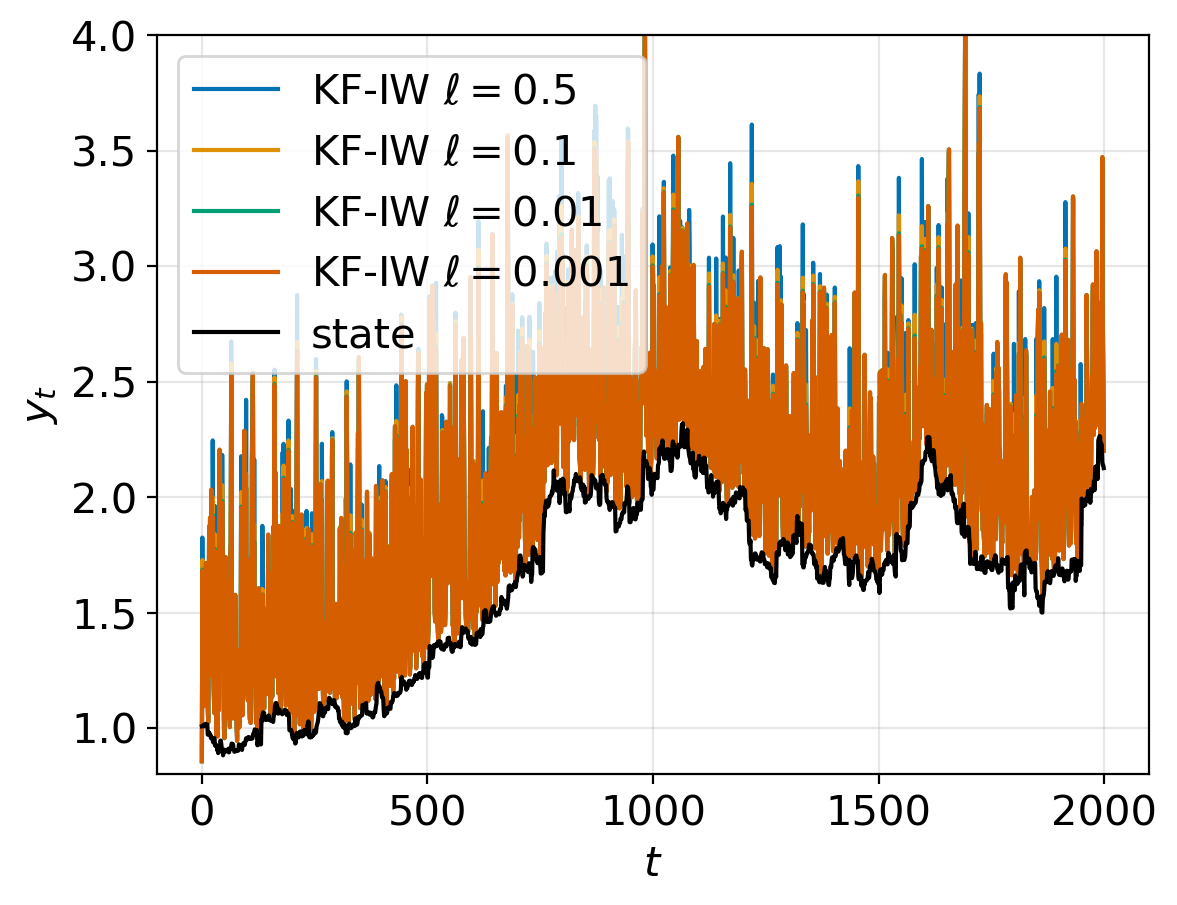

In [445]:
s_vals = [0.001, 0.01, 0.1, 0.5][::-1]
for s in s_vals:
    agent = rfilter.ExtendedKalmanFilterInverseWishart(
            latent_fn, measurement_fn, dynamics_covariance=1.0,
            prior_observation_covariance=1.0 * jnp.eye(1),
            n_inner=5, noise_scaling=s,
        )
    
    lr = 1.0
    bel_init = agent.init_bel(0.0, cov=lr)
    bel, yhat_pp_md = agent.scan(bel_init, y, x[:, None], callback_fn=callbacks.get_updated_mean)
    plt.plot(yhat_pp_md, label="KF-IW $\ell=$"f"{s}")

plt.plot(jnp.exp(hist["s"]), label="state", c="black")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("$t$")
plt.ylabel("$y_t$")
plt.ylim(0.8, 4.0)
plt.legend()
plt.savefig("./20240404-gamma-process-KF-IW.png", dpi=150)

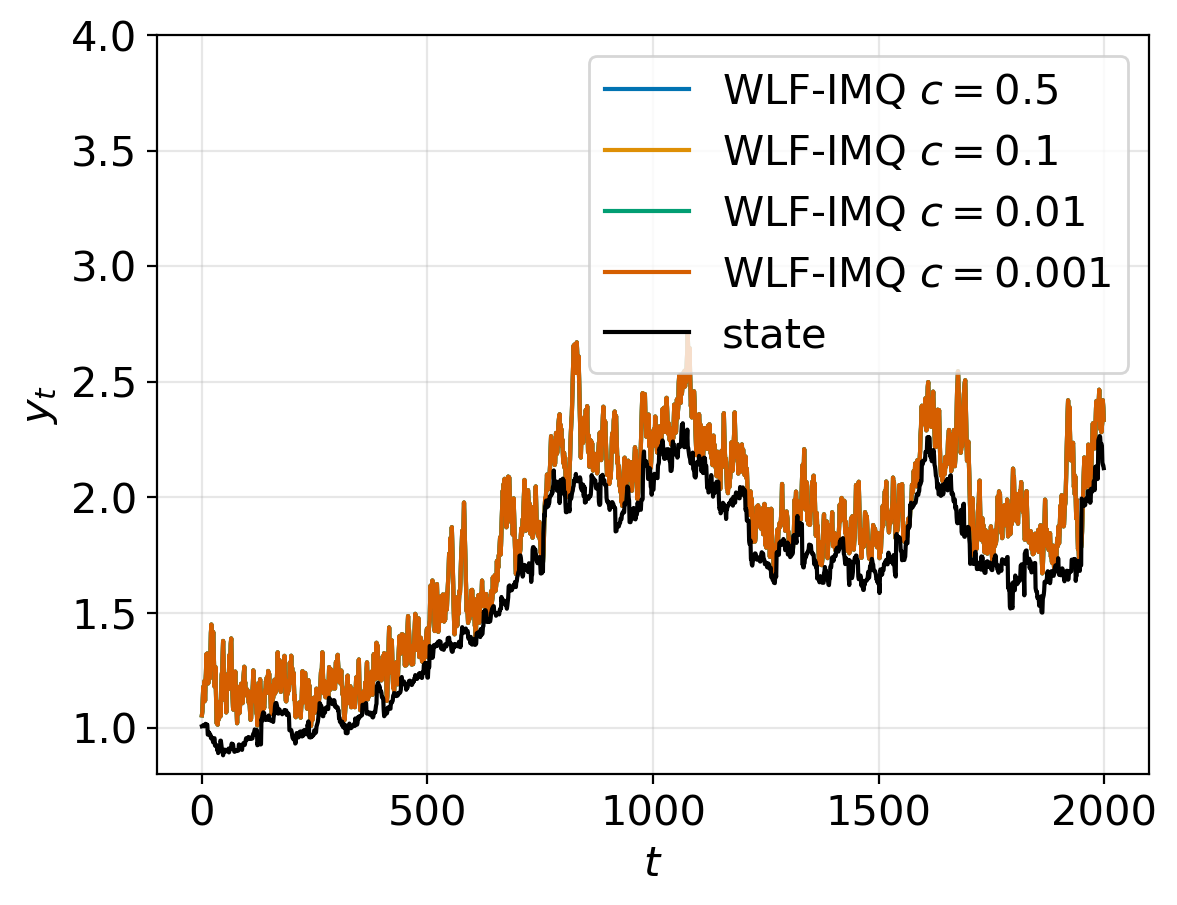

In [447]:
s_vals = [0.001, 0.01, 0.1, 0.5][::-1]
for s in s_vals:
    agent = rfilter.ExtendedKalmanFilterIMQ(
            latent_fn, measurement_fn, dynamics_covariance=1.0,
            observation_covariance=1.0 * jnp.eye(1),
            soft_threshold=0.1
        )
    
    lr = 1.0
    bel_init = agent.init_bel(1.0, cov=lr)
    bel, yhat_pp_imq = agent.scan(bel_init, y, x[:, None], callback_fn=callbacks.get_updated_mean)

    
    plt.plot(yhat_pp_imq, label="WLF-IMQ $c=$"f"{s}")
plt.plot(jnp.exp(hist["s"]), label="state", c="black")
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("$t$")
plt.ylabel("$y_t$")
plt.ylim(0.8, 4.0)
plt.legend()
plt.savefig("./20240404-gamma-process-WLF-IMQ.png", dpi=150)